# Jane Street Puzzles - April 2020

A solution by Walter Sebastian Gisler

## Problem Statement

Original source: https://www.janestreet.com/puzzles/current-puzzle/

Consider an equilateral triangular grid of dots with N rows, such as the one presented here (with N = 22). A “triad” is a set of 3 dots where each dot in the triad borders the other two. The top two rows of the triangular grid form a triad; all triads are (rotations of) precisely this shape.

For some values of N, it is possible to separate the triangular grid into disjoint triads such that every dot is a part of one triad. For example, it is obviously possible when N=2, but not when N=3 or N=4.

What is the sum of all values of N < 40 for which it is possible?

![Sample](triangular_2.png "Sample triangle")

## Solution

First of all, let's talk about representing the data here and let's write some code to display the solution in a Jupyter notebook. To represent a equilateral triangular grid, we can use a N x N matrix, which we will store in a dictionary for convenience. A 1 means that a dot is at a certain position, a 0 means, it isn't:

In [1]:
def triangular(N):
    return {(row,col): 1 if row >= col else 0 for row in range(N) for col in range(N)}

Next, let's define a method to display a triangular with matplotlib. We also need a method (here, called calculate_coordinate) that will calculate the coordinate where each triangular point will be displayed.

In [2]:
import matplotlib.pyplot as plt

def calculate_coordinate(N, row, col):
    y = N-row
    x = N/2-0.5*row+col
    return (x,y)

def draw_triangular(N, triangular, triads):
    %matplotlib inline
    xcords = []
    ycords = []
    for (row, col) in triangular:
        if triangular[(row, col)] == 1:
            (x,y) = calculate_coordinate(N, row, col)
            xcords.append(x)
            ycords.append(y)
    plt.scatter(xcords,ycords)
    for triad in triads:
        triad.append(triad[0])
        a = [calculate_coordinate(N, t[0], t[1]) for t in triad]
        plt.plot(*zip(*a))
    plt.show()

We can test this with a N = 9 triangular and three triads:

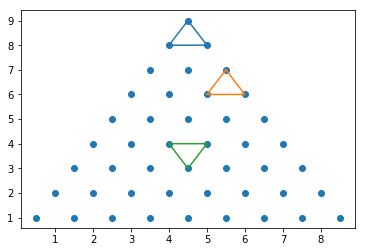

In [3]:
N = 9
tri = triangular(N)
draw_triangular(N, tri, [[(0,0), (1,0), (1,1)], [(2,2), (3,2), (3,3)], [[5,2], [5,3],[6,3]]])

Next, we will need a method that can fill in as many triads as possible. We will use integer linear programming for this. For each point of the triangular, we are adding two variables. There are two types of triads. Triads pointing down (in the graphic above, the blue and orange triad) and triads pointing down (the green triad). For upward pointing triads, a binary variable on the upward pointing corner has to be 1, for downward pointing triads, the binary variable on the downward pointing corner has to be 1. We also need to add a requirement that a point can be part of at most one triad and we need to make sure that every point of the triad is part of the triangular.

In [4]:
from docplex.mp.model import Model

def find_as_many_triads_as_possible(N, triangular):
    model = Model()
    
    # Variable definition
    tct = {(row,col): model.binary_var() if row >= col else 0 for row in range(N) for col in range(N)} # 1 = the point is the top corner of a triad
    bct = {(row,col): model.binary_var() if row >= col else 0 for row in range(N) for col in range(N)} # 1 = the point is the bottom corner of a triad
    
    # a point can only be part of one triad:
    for p in triangular:
        if triangular[p] > 0:
            all_adjacent_vars = [bct[p], tct[p]]
            if p[0]-1 >= 0 and p[1]-1 >= 0:
                all_adjacent_vars.append(tct[(p[0]-1, p[1]-1)])
            if p[0]-1 >= 0:
                all_adjacent_vars.append(tct[(p[0]-1, p[1])])
            if p[0]+1 < N and p[1]+1 < N:
                all_adjacent_vars.append(bct[(p[0]+1, p[1]+1)])
            if p[0]+1 < N:
                all_adjacent_vars.append(bct[(p[0]+1, p[1])])
            model.add(model.sum(all_adjacent_vars) <= 1)
    
    # certain points can't be a triad corner
    for p in triangular:
        if p[1] == 0: # there can't be a bottom corner triad if c == 1:
            model.add(bct[p] == 0)
        if p[0] == p[1]: # there can't be a bottom corner triad if c == r
            model.add(bct[p] == 0)
        if p[0] == N-1: # there can't be a top corner triad if r == N 
            model.add(tct[p] == 0)
            
    # The corner triads are given
    if N >= 2 and N != 3:
        model.add(tct[(0,0)] == 1)
        model.add(tct[(N-2,0)] == 1)
        model.add(tct[(N-2,N-2)] == 1)
            
    # maximize the number of triads and solve
    model.maximize(model.sum(tct[p] + bct[p] for p in triangular if triangular[p] > 0))
    model.solve(log_output = False)
    
    # return the solution
    result = []
    for p in triangular:
        if tct[p] and tct[p].solution_value >= 0.5:
            result.append([p, (p[0]+1, p[1]), (p[0]+1, p[1]+1)])
        if bct[p] and bct[p].solution_value >= 0.5:
            result.append([p, (p[0]-1, p[1]-1), (p[0]-1, p[1])])
    return result

Let's try this method with a triangular of size 9 and verify the result visually

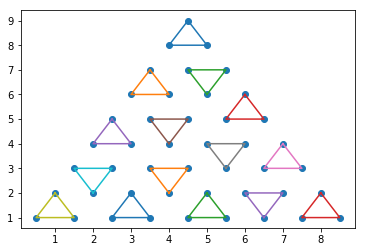

In [5]:
N = 9
tri = triangular(N)
r = find_as_many_triads_as_possible(N, tri)
draw_triangular(N, tri, r)

In this example, all points are part of a triad. We can check whether this is true by checking if the number of triads multiplied by 3 is equal to the number of points in the triangular:

In [6]:
print(len(r)*3 == sum(tri.values()))

True


Let's write a method that can tell us immediately if a triangular of size N can be split into disjoint triads such that every point is part of a triad:

In [7]:
def good_triangular(N):
    tri = triangular(N)
    if sum(tri.values()) % 3 != 0: # if the number of points can't be divided by 3, it is obviously not possible
        return False
    r = find_as_many_triads_as_possible(N, tri)
    return len(r)*3 == sum(tri.values())

With this method, we can now iterate through triangulars of size < 40 to see how many of them are "good" triangulars:

In [ ]:
count = 0

for N in range(1,40):
    good = good_triangular(N)
    print('Triangular of size %i: %s'%(N, str(good)))
    if good:
        count += N
        
print()
print('The answer is %i: '%count)

Triangular of size 1: False
Triangular of size 2: True
Triangular of size 3: False
Triangular of size 4: False
Triangular of size 5: False
Triangular of size 6: False
Triangular of size 7: False
Triangular of size 8: False
Triangular of size 9: True
Triangular of size 10: False
Triangular of size 11: True
Triangular of size 12: True
Triangular of size 13: False
Triangular of size 14: True
Triangular of size 15: False
Triangular of size 16: False
Triangular of size 17: False
Triangular of size 18: False
Triangular of size 19: False
Triangular of size 20: False
Triangular of size 21: True
Triangular of size 22: False
Triangular of size 23: True
Triangular of size 24: True
Triangular of size 25: False
Triangular of size 26: True


There we go, the puzzle is solved. Interestingly, for some triangulars it took a bit longer time to solve this. Interesting to see how quickly this problem gets quite difficult.

If we list the number of rows for equilateral triangulars that can be split into triads completely, we get the following sequence:

``` 0,  2,  9, 11,
12, 14, 21, 23,
24, 26, 33, 35,
36, 38, ...```

At this point it is likely that the sequence continues as follows:


```        45, 47, 
48, 50, 57, 59, 
60, 62, 69, 71, 
72, 74, 81, 83, 
84, 86, 93, 95, 
96, 98, 105, 107, 
108, 110, 117, 119,
...```

Sequences like this are usually listed in the online encyclopedia of integer sequences (OEIS). Indeed I was able to find this sequence with a reference to this exact problem: https://oeis.org/search?q=2%2C9%2C11%2C12%2C14%2C21%2C23%2C24%2C26&language=english&go=Search

The OEIS is always a great resource for problems like these. Obviously, it would have been sufficient to only have the first couple of Ns and I could have found the result.